In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import Scripts.airfoil as af
import Scripts.surfaceAreaEstimators as sea
import Scripts.volumeEstimators as ve
import Scripts.cotEstimators as ce

from pathlib import Path

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t

from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

In [2]:
def power_law(xData, a, b):
        return a * xData ** b

def fit_data(xData, yData):

    popt, pcov = curve_fit(power_law, xData, yData, p0=[1, 1])

    residuals = yData - power_law(xData, *popt)

    ss_res = np.sum(residuals**2)
    ss_total = np.sum((yData-np.mean(yData))**2)

    r_squared = 1 - (ss_res/ss_total)

    return popt, r_squared

In [3]:
dataBase = r'/home/mco143/Documents/gitRepos/fish_contours/PhillipsFitData.xlsx'
phillipsData = r'/home/mco143/Documents/gitRepos/fish_contours/phillips_COT_data.xlsx'
figurePath = r'/home/mco143/Documents/gitRepos/fish_contours/Figures'

In [4]:
# Fit Data
generalData = pd.read_excel(dataBase, sheet_name='General')
sideData = pd.read_excel(dataBase, sheet_name='Side Fit')
topData = pd.read_excel(dataBase, sheet_name='Top Fit')

# Phillips COT data
totalCOT = pd.read_excel(phillipsData, sheet_name="TotalCOTData")
optCOT = pd.read_excel(phillipsData, sheet_name="OptimumCOT")
hotelpower = pd.read_excel(phillipsData, sheet_name="HotelPower")
BMR = pd.read_excel(phillipsData, sheet_name="BMR")


In [5]:
# get species names
specimens = generalData['Species Name'].tolist()

In [6]:
lengthScales = np.linspace(0.01, 100, 50)

specimen = specimens[0]
idy = 0
sArea = np.zeros((len(lengthScales), len(specimens)))
D_calc = np.zeros((len(lengthScales), len(specimens)))
volume = np.zeros((len(lengthScales), len(specimens)))
blenderSA = np.zeros(len(lengthScales))
blenderVol = np.zeros(len(lengthScales))

for idy, specimen in enumerate(specimens):   
    sidePolyTop = sideData.loc[[idy],['Ta6', 'Ta5', 'Ta4', 'Ta3', 'Ta2', 'Ta1', 'Ta0']].values[0]
    sidePolyBottom = sideData.loc[[idy],['Ba6', 'Ba5', 'Ba4', 'Ba3', 'Ba2', 'Ba1', 'Ba0']].values[0]
    topNaca = topData.loc[[idy], ['Ta4', 'Ta3', 'Ta2']].values[0]
    sideArea = generalData.loc[[idy], ['Side Area']].values[0][0]
    topArea = generalData.loc[[idy], ['Top Area']].values[0][0]
    
    if (specimen == 'blenderSalmon'):
        for idx, length in enumerate(lengthScales):
            sArea[idx, idy], D_calc[idx, idy] = sea.determine_surface_area(1, 2, 0, length, sidePolyTop, sidePolyBottom, topNaca, topNaca)
            blenderSA[idx] = sArea[idx, idy]
            volume[idx, idy] = ve.determine_volume(1, 2, 0, length, sidePolyTop, sidePolyBottom, topNaca, topNaca)
            blenderVol[idx] = volume[idx, idy]
    else:   
        for idx, length in enumerate(lengthScales):
            sArea[idx, idy], D_calc[idx, idy] = sea.determine_surface_area(1, 2, 0, length, sidePolyTop, sidePolyBottom, topNaca, topNaca)
            volume[idx, idy] = ve.determine_volume(1, 2, 0, length, sidePolyTop, sidePolyBottom, topNaca, topNaca)

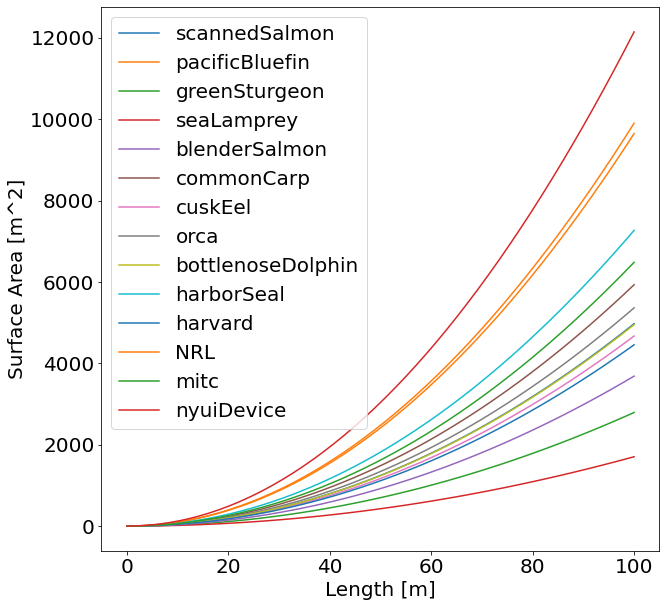

In [7]:
plt.rcParams.update({'font.size': 20})

fig1, ax1 = plt.subplots(figsize=((10, 10)))

for idy, specimen in enumerate(specimens):
    ax1.plot(lengthScales, sArea[:, idy], label=specimen)

ax1.set_ylabel('Surface Area [m^2]')
ax1.set_xlabel('Length [m]')
ax1.legend()

In [8]:
mammal_hp = BMR.loc[BMR['Species']=='Mammal']
eel_hp = BMR.loc[BMR['Species']=='Eel']
salmon_hp = BMR.loc[BMR['Species']=='Salmonoid']
AUV_hp = BMR.loc[BMR['Species']=='AUV']
glider_hp = BMR.loc[BMR['Species']=='Glider']

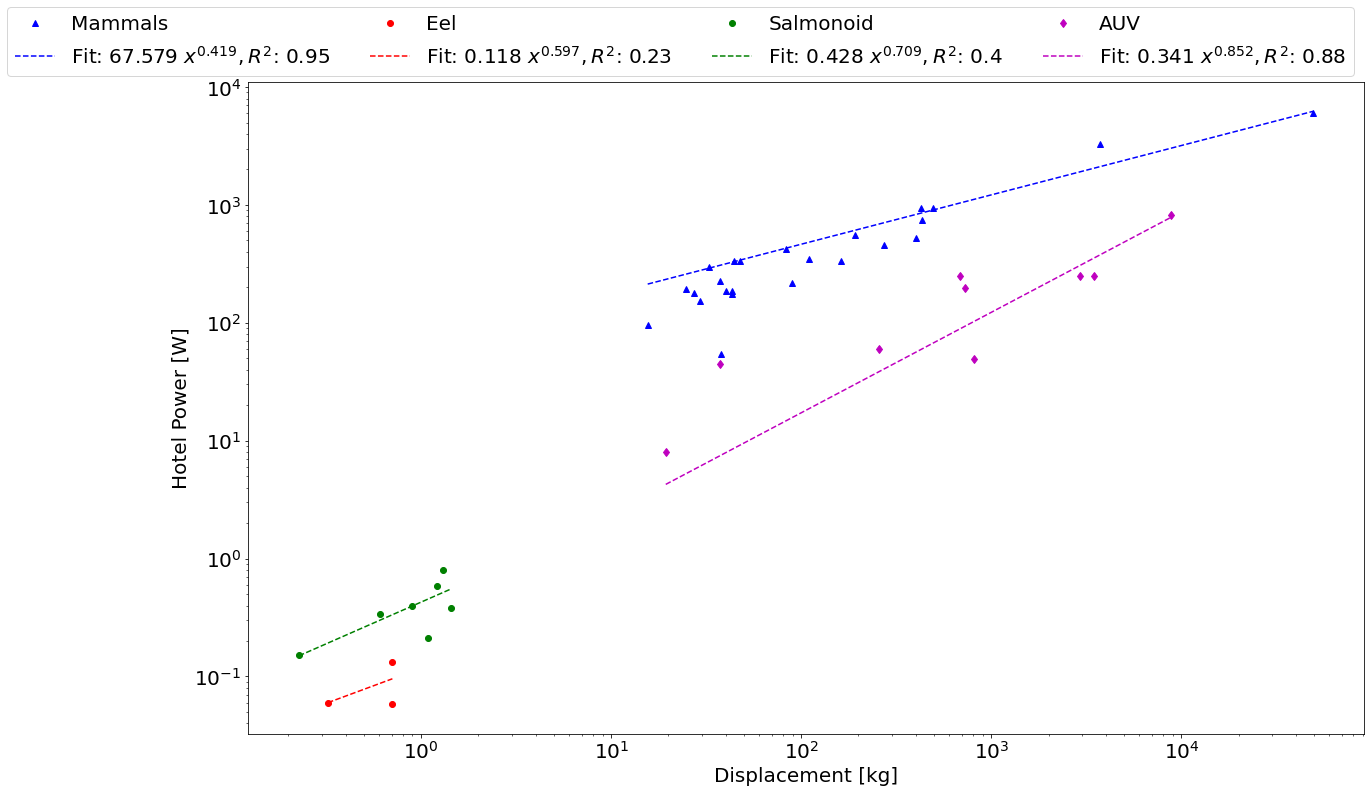

In [16]:
popt_mammal, r_sq_mammal = fit_data(mammal_hp["Displacement"].values, mammal_hp["MR"].values)
popt_eel, r_sq_eel = fit_data(eel_hp["Displacement"].values, eel_hp["MR"].values)
popt_salmon, r_sq_salmon = fit_data(salmon_hp["Displacement"].values, salmon_hp["MR"].values)
popt_AUV, r_sq_AUV = fit_data(AUV_hp["Displacement"].values, AUV_hp["MR"].values)
#popt_glider, r_sq_glider = fit_data(glider_hp["Displacement"].values, glider_hp["MR"].values)


fig3, ax3 = plt.subplots(figsize=((20, 12)))
fig3.set_facecolor('white')
ax3.loglog(mammal_hp["Displacement"].values, mammal_hp["MR"].values, 'b^', label='Mammals')
ax3.loglog(mammal_hp["Displacement"].values, power_law(mammal_hp["Displacement"].values, *popt_mammal), 'b--', label="Fit: " + str(np.round(popt_mammal[0], 3)) + " $x^{" + str(np.round(popt_mammal[1], 3)) + '}, R^2$: ' + str(np.round(r_sq_mammal, 2)))
ax3.loglog(eel_hp["Displacement"].values, eel_hp["MR"].values, 'ro', label='Eel')
ax3.loglog(eel_hp["Displacement"].values, power_law(eel_hp["Displacement"].values, *popt_eel), 'r--', label="Fit: " + str(np.round(popt_eel[0], 3)) + " $x^{" + str(np.round(popt_eel[1], 3)) + '}, R^2$: ' + str(np.round(r_sq_eel, 2)))
ax3.loglog(salmon_hp["Displacement"].values, salmon_hp["MR"].values, 'go', label='Salmonoid')
ax3.loglog(salmon_hp["Displacement"].values, power_law(salmon_hp["Displacement"].values, *popt_salmon), 'g--', label="Fit: " + str(np.round(popt_salmon[0], 3)) + " $x^{" + str(np.round(popt_salmon[1], 3)) + '}, R^2$: ' + str(np.round(r_sq_salmon, 2)))
ax3.loglog(AUV_hp["Displacement"].values, AUV_hp["MR"].values, 'md', label='AUV')
ax3.loglog(AUV_hp["Displacement"].values, power_law(AUV_hp["Displacement"].values, *popt_AUV), 'm--', label="Fit: " + str(np.round(popt_AUV[0], 3)) + " $x^{" + str(np.round(popt_AUV[1], 3)) + '}, R^2$: ' + str(np.round(r_sq_AUV, 2)))
ax3.set_ylabel('Hotel Power [W]')
ax3.set_xlabel('Displacement [kg]')
ax3.legend(ncol=4, bbox_to_anchor=(1.0, 1.13))
fig3.savefig(Path(figurePath).joinpath('hotel_power.png'), facecolor='w', bbox_inches='tight')

In [10]:
def get_hotel_power(mass, animal_type):
    if(animal_type == 'Mammal'):
        return 67.579*mass**0.419
    elif(animal_type == 'Eel'):
        return 0.118*mass**0.597
    elif(animal_type == 'Salmonoid'):
        return 0.428*mass**0.709
    elif(animal_type == "AUV"):
        0.341*mass**0.852
    else:
        return 3.39*mass**0.75

In [11]:
cot_all_temp = {"Animal":[], "Displacement":[], "Velocity":[], "COT_Raw":[], "Re":[], "Length":[], "D_calc":[], "SR":[], "COT_calc":[], "COT_Ellipse":[]}
efficiency = 0.81
kinVisc = 1.19e-6
fluidDensity = 1025
animals = totalCOT["Animal"]

for idy, animal in enumerate(animals):
    animal_type = totalCOT.loc[[idy],["Type"]].values[0]
    displacement = totalCOT.loc[[idy],["Displacement"]].values[0]
    length = totalCOT.loc[[idy],["Length"]].values[0]
    velocity = totalCOT.loc[[idy],["Velocity"]].values[0]
    sidePolyTop = totalCOT.loc[[idy],['Ta6', 'Ta5', 'Ta4', 'Ta3', 'Ta2', 'Ta1', 'Ta0']].values[0]
    sidePolyBottom = totalCOT.loc[[idy],['Ba6', 'Ba5', 'Ba4', 'Ba3', 'Ba2', 'Ba1', 'Ba0']].values[0]
    topNaca = totalCOT.loc[[idy], ['Nta4', 'Nta3', 'Nta2']].values[0]
    sideArea = totalCOT.loc[[idy], ['Side Area']].values[0]
    topArea = totalCOT.loc[[idy], ['Top Area']].values[0]
    Re = totalCOT.loc[[idy], ['Re']].values[0]
    cot_raw = totalCOT.loc[[idy],['COT']].values[0]
     
    surfaceArea, D_calc = sea.determine_surface_area(1, 2, 0, length, sidePolyTop, sidePolyBottom, topNaca, topNaca)
    surfaceArea = surfaceArea + (surfaceArea * topArea)
    ellipseSA, ellipseD_calc, ellipseSR = sea.equivalentSpheroid(length, displacement, fluidDensity)
    SR = length/D_calc

    pp_calc = ce.ITTC_pp(SR, surfaceArea, length, displacement, efficiency, kinVisc, fluidDensity, velocity)
    ellipse_pp_calc = ce.ITTC_pp(ellipseSR, ellipseSA, length, displacement, efficiency, kinVisc, fluidDensity, velocity)
    hotel_power = get_hotel_power(displacement, animal_type)
    cot_calc = (hotel_power + pp_calc)/(displacement*velocity)
    cot_ellipse = (hotel_power + ellipse_pp_calc)/(displacement*velocity)

    cot_all_temp['Animal'].append(animal)
    cot_all_temp["Displacement"].append(displacement[0])
    cot_all_temp["Velocity"].append(velocity[0])
    cot_all_temp["COT_Raw"].append(cot_raw[0])
    cot_all_temp["Re"].append(Re[0])
    cot_all_temp["Length"].append(length[0])
    cot_all_temp["D_calc"].append(D_calc)
    cot_all_temp["SR"].append(SR[0])
    cot_all_temp["COT_calc"].append(cot_calc[0])
    cot_all_temp["COT_Ellipse"].append(cot_ellipse[0])

cot_all_data = pd.DataFrame(cot_all_temp)

In [12]:
 killerWhale_cot = cot_all_data.loc[(cot_all_data["Animal"] == "orca")]
 carp_cot = cot_all_data.loc[(cot_all_data["Animal"] == "commonCarp")]
 sturgeon_cot = cot_all_data.loc[(cot_all_data["Animal"] == "greenSturgeon")]
 silverEel_cot = cot_all_data.loc[(cot_all_data["Animal"] == "Silver Eel")]
 harbourSeal_cot = cot_all_data.loc[(cot_all_data["Animal"] == "harbourSeal")]
 kerala_cot = cot_all_data.loc[(cot_all_data["Animal"] == "keralaMystus")]

In [13]:
popt_orca, r_sq_orca = fit_data(killerWhale_cot["Velocity"].values, killerWhale_cot["COT_Raw"].values)
popt_carp, r_sq_carp = fit_data(carp_cot["Velocity"].values, carp_cot["COT_Raw"].values)
popt_sturgeon, r_sq_sturgeon = fit_data(sturgeon_cot["Velocity"].values, sturgeon_cot["COT_Raw"].values)
popt_silverEel, r_sq_silverEel = fit_data(silverEel_cot["Velocity"].values, silverEel_cot["COT_Raw"].values)
popt_harbourSeal, r_sq_harbourSeal= fit_data(harbourSeal_cot["Velocity"].values, harbourSeal_cot["COT_Raw"].values)
popt_kerala, r_sq_kerala = fit_data(kerala_cot["Velocity"].values, kerala_cot["COT_Raw"].values)

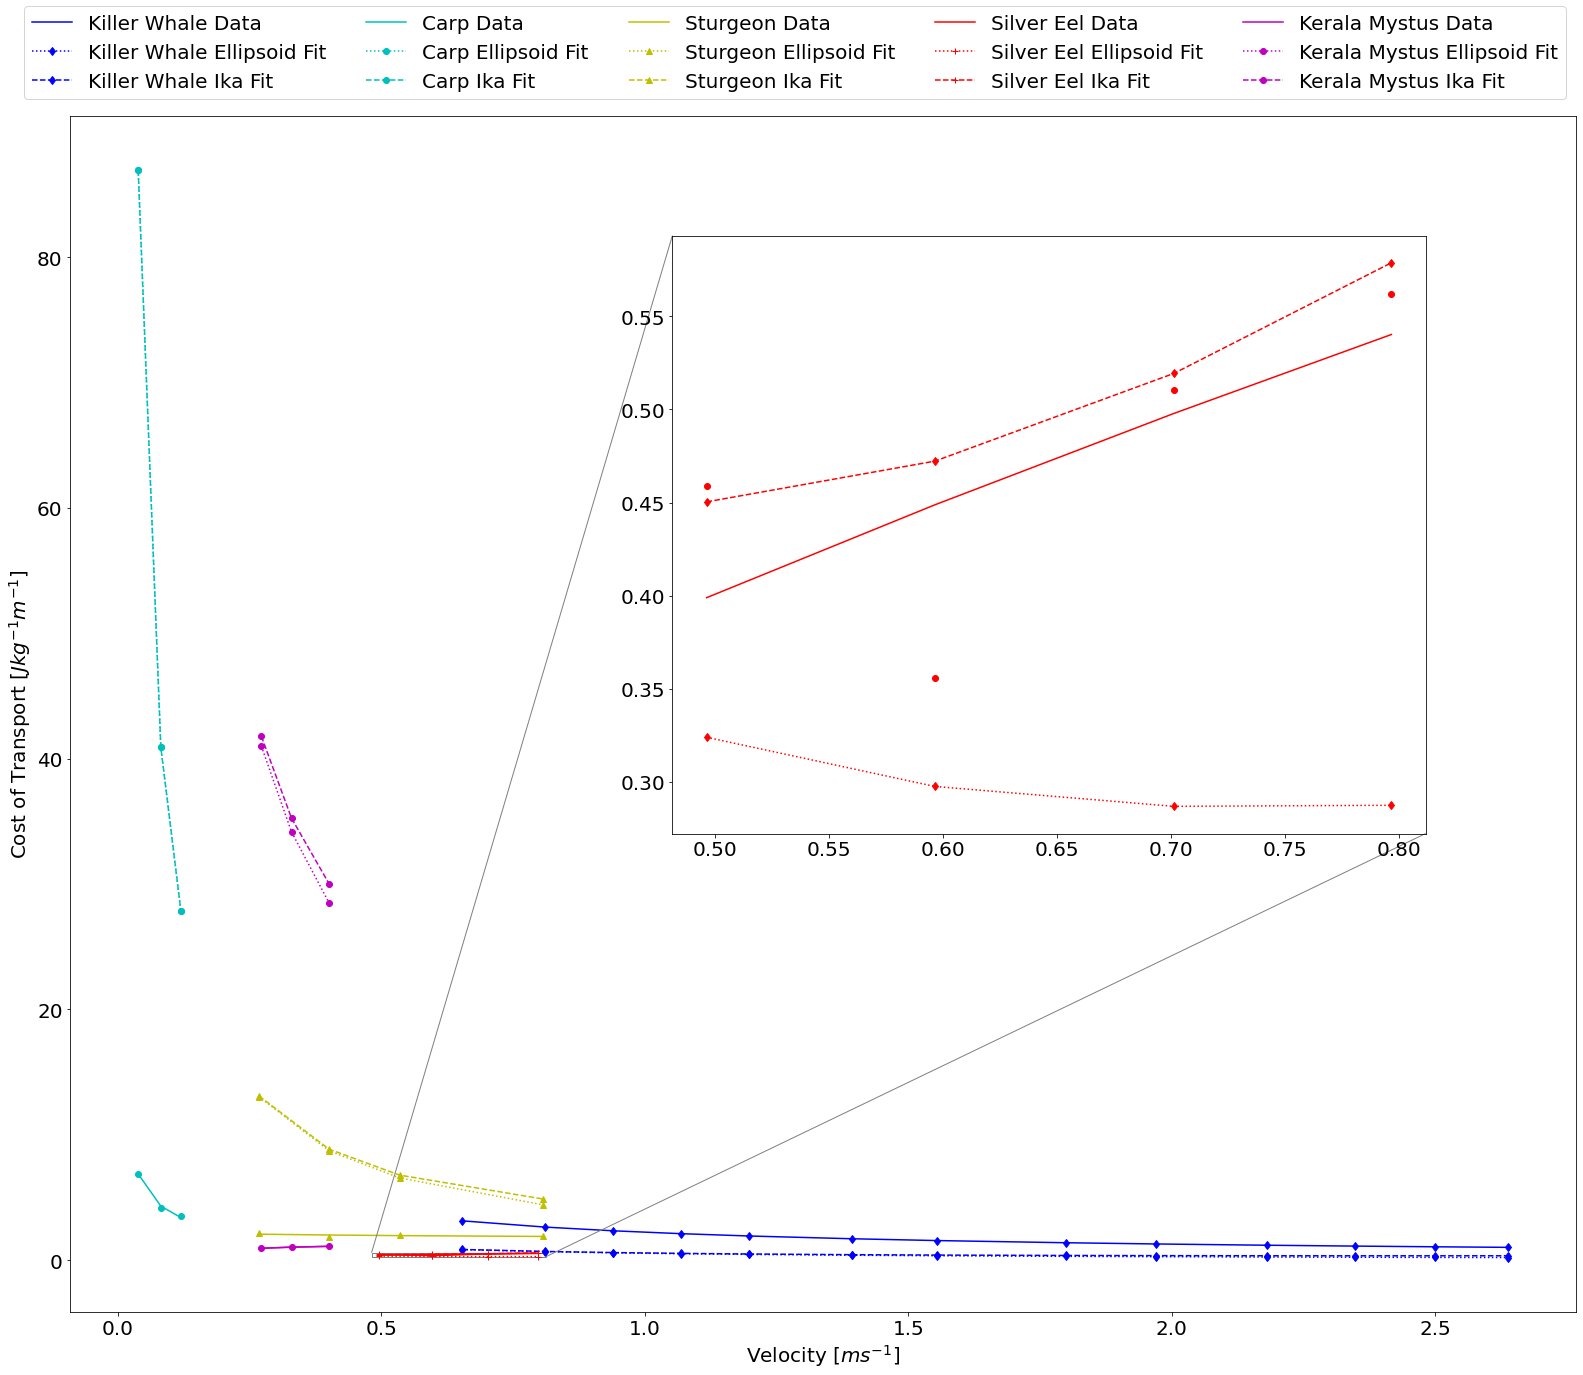

In [14]:
fig4, ax4 = plt.subplots(figsize=(27,22))
# Orca Data
ax4.plot(killerWhale_cot["Velocity"], killerWhale_cot["COT_Raw"], 'bd')
ax4.plot(killerWhale_cot["Velocity"].values, power_law(killerWhale_cot["Velocity"].values, *popt_orca), 'b-', label='Killer Whale Data')
ax4.plot(killerWhale_cot["Velocity"], killerWhale_cot["COT_Ellipse"], 'bd:', label="Killer Whale Ellipsoid Fit")
ax4.plot(killerWhale_cot["Velocity"], killerWhale_cot["COT_calc"], 'bd--', label="Killer Whale Ika Fit")
# Carp Data
ax4.plot(carp_cot["Velocity"], carp_cot["COT_Raw"], 'co')
ax4.plot(carp_cot["Velocity"].values, power_law(carp_cot["Velocity"].values, *popt_carp), 'c-', label='Carp Data')
ax4.plot(carp_cot["Velocity"], carp_cot["COT_Ellipse"], 'co:', label="Carp Ellipsoid Fit")
ax4.plot(carp_cot["Velocity"], carp_cot["COT_calc"], 'co--', label="Carp Ika Fit")
# Sturgeon Data
ax4.plot(sturgeon_cot["Velocity"], sturgeon_cot["COT_Raw"], 'y^')
ax4.plot(sturgeon_cot["Velocity"].values, power_law(sturgeon_cot["Velocity"].values, *popt_sturgeon), 'y-', label='Sturgeon Data')
ax4.plot(sturgeon_cot["Velocity"], sturgeon_cot["COT_Ellipse"], 'y^:', label="Sturgeon Ellipsoid Fit")
ax4.plot(sturgeon_cot["Velocity"], sturgeon_cot["COT_calc"], 'y^--', label="Sturgeon Ika Fit")
# Silver Eel Data
ax4.plot(silverEel_cot["Velocity"], silverEel_cot["COT_Raw"], 'r+-')
ax4.plot(silverEel_cot["Velocity"].values, power_law(silverEel_cot["Velocity"].values, *popt_silverEel), 'r-', label='Silver Eel Data')
ax4.plot(silverEel_cot["Velocity"], silverEel_cot["COT_Ellipse"], 'r+:', label="Silver Eel Ellipsoid Fit")
ax4.plot(silverEel_cot["Velocity"], silverEel_cot["COT_calc"], 'r+--', label="Silver Eel Ika Fit")
# Kerala Data
ax4.plot(kerala_cot["Velocity"], kerala_cot["COT_Raw"], 'mo-')
ax4.plot(kerala_cot["Velocity"].values, power_law(kerala_cot["Velocity"].values, *popt_kerala), 'm-', label='Kerala Mystus Data')
ax4.plot(kerala_cot["Velocity"], kerala_cot["COT_Ellipse"], 'mo:', label="Kerala Mystus Ellipsoid Fit")
ax4.plot(kerala_cot["Velocity"], kerala_cot["COT_calc"], 'mo--', label="Kerala Mystus Ika Fit")
ax4.set_xlabel("Velocity $[ms^{-1}]$")
ax4.set_ylabel("Cost of Transport $[Jkg^{-1}m^{-1}]$")
ax4.legend(loc='best', ncol=5, bbox_to_anchor=(1.0, 1.1))

ax5 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax1, [0.4,0.4,0.5,0.5])
ax5.set_axes_locator(ip)
mark_inset(ax4, ax5, loc1=2, loc2=4, fc="none", ec='0.5')
ax5.plot(silverEel_cot["Velocity"], silverEel_cot["COT_Raw"], 'ro')
ax5.plot(silverEel_cot["Velocity"].values, power_law(silverEel_cot["Velocity"].values, *popt_silverEel), 'r-')
ax5.plot(silverEel_cot["Velocity"], silverEel_cot["COT_Ellipse"], 'rd:')
ax5.plot(silverEel_cot["Velocity"], silverEel_cot["COT_calc"], 'rd--')
fig4.savefig(Path(figurePath).joinpath('Full_COT.png'), facecolor='w', bbox_inches='tight')

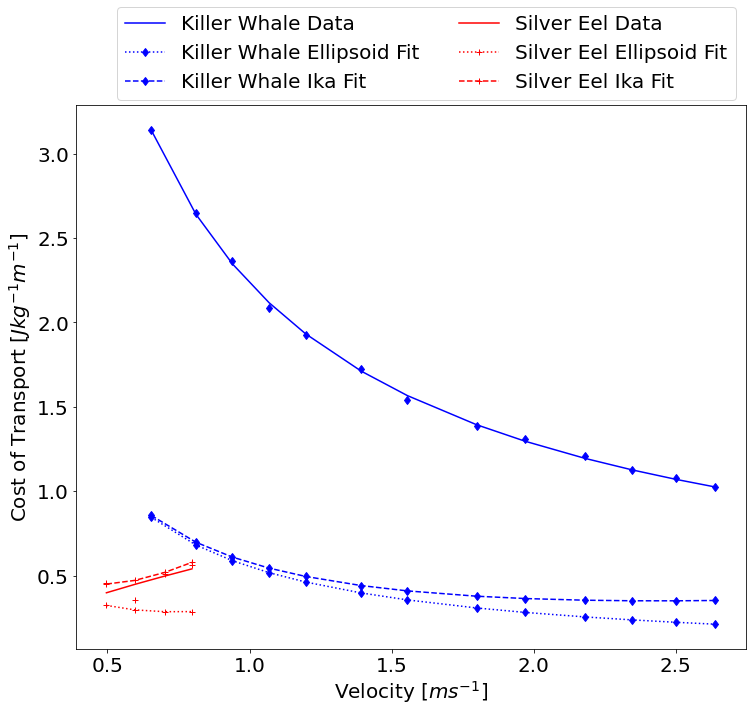

In [17]:
fig5, ax5 = plt.subplots(figsize=(12,10))
# Orca Data
ax5.plot(killerWhale_cot["Velocity"], killerWhale_cot["COT_Raw"], 'bd')
ax5.plot(killerWhale_cot["Velocity"].values, power_law(killerWhale_cot["Velocity"].values, *popt_orca), 'b-', label='Killer Whale Data')
ax5.plot(killerWhale_cot["Velocity"], killerWhale_cot["COT_Ellipse"], 'bd:', label="Killer Whale Ellipsoid Fit")
ax5.plot(killerWhale_cot["Velocity"], killerWhale_cot["COT_calc"], 'bd--', label="Killer Whale Ika Fit")
# Silver Eel Data
ax5.plot(silverEel_cot["Velocity"], silverEel_cot["COT_Raw"], 'r+')
ax5.plot(silverEel_cot["Velocity"].values, power_law(silverEel_cot["Velocity"].values, *popt_silverEel), 'r-', label='Silver Eel Data')
ax5.plot(silverEel_cot["Velocity"], silverEel_cot["COT_Ellipse"], 'r+:', label="Silver Eel Ellipsoid Fit")
ax5.plot(silverEel_cot["Velocity"], silverEel_cot["COT_calc"], 'r+--', label="Silver Eel Ika Fit")
ax5.set_xlabel("Velocity $[ms^{-1}]$")
ax5.set_ylabel("Cost of Transport $[Jkg^{-1}m^{-1}]$")
ax5.legend(loc='best', ncol=2, bbox_to_anchor=(1.0, 1.2))
fig5.savefig(Path(figurePath).joinpath("Orca_eel_comparison.png"), facecolor='w', bbox_inches='tight')

13    86.925768
14    40.908720
15    27.821446
Name: COT_Ellipse, dtype: float64
